## Prep traj outputs from stream

In [2]:
# Removes CPU usage limit by some jupyter versions
import os
os.environ['KMP_AFFINITY'] = ''
# Configure matplotlib to enable large animations
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
import matplotlib.pyplot as plt
# Prepare trajectory files
import pandas as pd
#import dictys

# path to stream outputs
stream_outs = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs"
dictys_data_path = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/data"

In [3]:
# Load data
dist = pd.read_csv(os.path.join(stream_outs, 'dist.tsv.gz'), header=0, index_col=0, sep='\t')
edge = pd.read_csv(os.path.join(stream_outs, 'edge.tsv.gz'), header=None, index_col=None, sep='\t')
branch = pd.read_csv(os.path.join(stream_outs, 'branch.tsv.gz'), header=None, index_col=None, sep='\t')

# Display the first few rows of each DataFrame to confirm successful loading
print("dist DataFrame:")
display(dist.head())
print("dist DataFrame shape:", dist.shape)

# print("edge DataFrame:")
# display(edge.head())

# print("branch DataFrame:")
# display(branch.head())
# print("branch DataFrame shape:", branch.shape)

dist DataFrame:


S0        S1        S2        S3
AAACAGCCAAGCCACT-3  0.003930  0.010666  0.006064  0.000259
AAACAGCCAAGGTGCA-1  0.000728  0.007464  0.001405  0.004918
AAACAGCCAAGTTATC-1  0.000459  0.006277  0.002593  0.004648
AAACAGCCAATAGCCC-1  0.000553  0.007288  0.001581  0.004742
AAACAGCCAGTTAGCC-1  0.000495  0.007230  0.001639  0.004684

dist DataFrame shape: (28236, 4)


In [3]:
# Save data
traj = dictys.traj.trajectory.fromdist(edge.values, dist.values)
traj_file_path = os.path.join(dictys_data_path, 'traj_node.h5')
traj.to_file(traj_file_path)

point = dictys.traj.point.fromdist(traj, branch.values, dist.values)
point_file_path = os.path.join(dictys_data_path, 'traj_cell_rna.h5')
point.to_file(point_file_path, traj=False)

In [4]:
# inspect the output .h5 files
import h5py
traj_file = h5py.File(traj_file_path, 'r')
point_file = h5py.File(point_file_path, 'r')

# print keys
print("traj_file keys:", traj_file.keys())
print("point_file keys:", point_file.keys())

#print values
print("traj_file values:")
for key in traj_file.keys():
    print(key, ":", traj_file[key])

print("point_file values:")
for key in point_file.keys():
    print(key, ":", point_file[key])

traj_file keys: <KeysViewHDF5 ['edges', 'lens']>
point_file keys: <KeysViewHDF5 ['edges', 'locs']>
traj_file values:
edges : <HDF5 dataset "edges": shape (3, 2), type "<i8">
lens : <HDF5 dataset "lens": shape (3,), type "<f8">
point_file values:
edges : <HDF5 dataset "edges": shape (28236,), type "<i8">
locs : <HDF5 dataset "locs": shape (28236,), type "<f8">


In [5]:
################# Check the subsets output #################
#Cell subset list
!head $dictys_data_path/subsets.txt

Activated_B_Cells
Day_1_Cells
Day_3_Cells
Germinal_Center
Plasma_Blast
Undefined


## Prepare configs for network inference

In [1]:
%%bash
# Generate configuration template
rm -Rf /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/makefiles
mkdir /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/makefiles
cd /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/makefiles
dictys_helper makefile_template.sh common.mk config.mk env_none.mk dynamic.mk

# Update configurations, such as:
# DEVICE: pytorch device, e.g. cpu, cuda:0. If you do not have a GPU, use 'cpu' and expect LONG computing time.
# GENOME_MACS2: effective genome size for macs2. See https://deeptools.readthedocs.io/en/develop/content/feature/effectiveGenomeSize.html
# JOINT: whether dataset is joint profiling of RNA and ATAC.
# Other configurations include quality control thresholds, number of threads in each job, number of hidden confounders, etc.
# They can be obtained in the full-multiome tutorial.
dictys_helper makefile_update.py /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/makefiles/config.mk '{"DEVICE": "cuda:0", "GENOME_MACS2": "hs", "JOINT": "1"}'


#### * Edit the config.mk params for your dataset

In [2]:
!dictys_helper makefile_check.py --dir_data /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/data --dir_makefiles /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/makefiles

Joint profile: True
Found 36306 cells with RNA profile
Found 24026 genes with RNA profile
Found 36306 cells with ATAC profile
Found 769 motifs
Found 678 TFs
Found 461 TFs in current dataset
Missing 217 TFs in current dataset: ANDR,AP2A,AP2B,AP2C,AP2D,ARI3A,ARI5B,ATF6A,BARH1,BARH2,BC11A,BHA15,BHE22,BHE23,BHE40,BHE41,BMAL1,BRAC,BSH,COE1,COT1,COT2,CR3L1,CR3L2,ERR1,ERR2,ERR3,EVI1,GCR,HEN1,HMBX1,HME1,HME2,HNF6,HTF4,HXA1,HXA10,HXA11,HXA13,HXA2,HXA5,HXA7,HXA9,HXB1,HXB13,HXB2,HXB3,HXB4,HXB6,HXB7,HXB8,HXC10,HXC11,HXC12,HXC13,HXC6,HXC8,HXC9,HXD10,HXD11,HXD12,HXD13,HXD3,HXD4,HXD8,HXD9,ITF2,KAISO,MCR,MGAP,MLXPL,MYBA,MYBB,NDF1,NDF2,NF2L1,NF2L2,NFAC1,NFAC2,NFAC3,NFAC4,NGN2,NKX21,NKX22,NKX23,NKX25,NKX28,NKX31,NKX32,NKX61,NKX62,ONEC2,ONEC3,OZF,P53,P5F1B,P63,P73,PEBB,PHX2A,PHX2B,PIT1,PKNX1,PLAL1,PO2F1,PO2F2,PO2F3,PO3F1,PO3F2,PO3F3,PO3F4,PO4F1,PO4F2,PO4F3,PO5F1,PO6F1,PO6F2,PRD14,PRGR,RHXF1,RORG,RX,SMCA1,SMCA5,SRBP1,SRBP2,STA5A,STA5B,STF1,SUH,TF2LX,TF65,TF7L1,TF7L2,TFE2,THA,THA11,THB,TWST1,TYY1,TYY2,UBIP

#### Subset cells along the trajectory into moving windows (~12 hrs > could be heavily improved by parallelization)

# Prepare preproc and chromatin files for subset 1 for dynamic network inference

#### Slice expression gene by cell matirx from the total gene by cell (~7 mins for subset1)

In [1]:
%%bash
# move into working directory
cd /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs
# slice gene_by_cell for subset 1
dictys preproc selects_rna data/expression.tsv.gz tmp_dynamic/Subset1/names_rna.txt tmp_dynamic/Subset1/expression0.tsv.gz

#### QC the sliced gene by cell (~1min)

In [2]:
%%bash
# move into working directory
cd /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs
# QC gene_by_cell for subset 1 {min cell and gene depth 10, 10} {min cell and gene occurence 1, 1} {min cell and gene proportion 0, 0}
dictys preproc qc_reads tmp_dynamic/Subset1/expression0.tsv.gz tmp_dynamic/Subset1/expression.tsv.gz 10 1 0 10 1 0

#### Select atac files for the post qc cells (~3 sec)

In [5]:
%%bash
# move into working directory
cd /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs
# get atac names for post QC cells 
dictys preproc selects_atac tmp_dynamic/Subset1/expression.tsv.gz tmp_dynamic/Subset1/names_atac0.txt tmp_dynamic/Subset1/names_atac.txt

#### Make a combined bam for a window using samtools (~7 mins) (dictys' bash script runs)

#### Call peaks from the combined atac bam file for a window (~7 mins)

In [1]:
import subprocess
import pandas as pd
import numpy as np
import os
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

# Define your paths and parameters
working_dir = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/tmp_dynamic/Subset1'
bam_file = os.path.join(working_dir, 'reads.bam')
output_bed = os.path.join(working_dir, 'peaks.bed')
output_prefix = '04'
genome_size = 'hs'  # human
q_value_cutoff = 0.05
number_of_threads = 4  # Adjust based on available resources

# Command to call peaks using macs2 with verbose output
macs2_command = [
    'macs2', 'callpeak',
    '-t', bam_file,       # Input BAM file
    '-f', 'BAM',          # BAM format
    '-n', output_prefix,  # Output name prefix
    '-g', genome_size,    # Genome size
    '--nomodel',          # Disable model building
    '--shift', '-75',     # Shift reads by -75bp
    '--extsize', '150',   # Extend size by 150bp
    '--keep-dup', 'all',  # Keep all duplicates
    '--call-summits',     # Call summits of peaks
    '-q', str(q_value_cutoff),  # Q-value cutoff
    '--verbose', '4'      # Verbose output level
]

# Run the command from the specified working directory
try:
    result = subprocess.run(macs2_command, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, cwd=working_dir)
    # Print the stdout for detailed log
    print(result.stdout.decode('utf-8'))
except subprocess.CalledProcessError as e:
    # Print the stderr in case of error
    print(f"MACS2 peak calling failed: {e.stderr.decode('utf-8')}")

# Rename the .narrowPeak file to .bed
narrowPeak_file = os.path.join(working_dir, f'{output_prefix}_peaks.narrowPeak')
if os.path.isfile(narrowPeak_file):
    os.rename(narrowPeak_file, output_bed)
    print(f"Renamed {narrowPeak_file} to {output_bed}")
else:
    print(f"Error: {narrowPeak_file} not found.")



Renamed /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/tmp_dynamic/Subset1/04_peaks.narrowPeak to /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/tmp_dynamic/Subset1/peaks.bed


#### Filter the called peaks (~3 sec)

In [2]:
import pandas as pd
import numpy as np
import os
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

# Define paths
working_dir = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/tmp_dynamic/Subset1'
peaks_bed_file = os.path.join(working_dir, 'peaks.bed')  # The .bed file generated from macs2

# Load the peaks file
df_peaks = pd.read_csv(peaks_bed_file, sep='\t', header=None)

# Set the number of maximum peaks to retain
nmax = 500000  # taken from dictys chromatin script

# Sort and filter the peaks by score if needed
if nmax > 0 and len(df_peaks) > nmax:
    logging.info(f"Reducing number of peaks to top {nmax} based on score.")
    
    # Get the score threshold that retains the top `nmax` peaks
    score_threshold = np.partition(df_peaks[8].values, -nmax-1)[-nmax-1]
    
    # Filter the peaks with score greater than the threshold
    filtered_peaks = df_peaks[df_peaks[8] > score_threshold]

    # Save the filtered peaks back to the same file
    logging.info(f"Writing filtered peaks back to {peaks_bed_file}")
    filtered_peaks.to_csv(peaks_bed_file, sep='\t', header=False, index=False)
else:
    logging.info(f"Number of peaks is below {nmax}. No filtering applied.")

# Completion message
print(f"Peak filtering completed. The file is saved at: {peaks_bed_file}")


INFO:root:Number of peaks is below 500000. No filtering applied.


Peak filtering completed. The file is saved at: /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/tmp_dynamic/Subset1/peaks.bed


#### Call TF footprints within the peaks using pydnase/wellington (input blacklist region of the genome for footprinting) (~3 mins)

In [ ]:
%%bash
#!/bin/bash
#SBATCH --job-name="footprinting"
#SBATCH --output="footprint_S1.log"

#SBATCH -p RM
#SBATCH -N 1 # by default for gpu-shared you can only request 1 node
#SBATCH -t 6:00:00 # wall-time
#SBATCH --ntasks-per-node=128 # number of cores per node; memory is 2gb per node for rm-shared

# Set the working directory to where data and makefiles are located
WORK_DIR="/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs"

# Change directory to the working directory
cd $WORK_DIR || { echo "Error: Could not change directory to $WORK_DIR"; exit 1; }

################ RUN dictys in dynamic mode ################
# max footprints is set to 100k in default params for wellington function in dictys
module load anaconda3/2022.10
source activate dictys
dictys chromatin wellington --nth 64 --fi_blacklist data/blacklist.bed tmp_dynamic/Subset1/reads.bam tmp_dynamic/Subset1/reads.bai tmp_dynamic/Subset1/peaks.bed tmp_dynamic/Subset1/footprints.bed


***** WARNING: File /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/tmp_dynamic/Subset1/peaks.bed has inconsistent naming convention for record:
KI270330.1	234	553	04_peak_1	63	.	4.61637	8.36136	6.36608	93

***** WARNING: File /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/tmp_dynamic/Subset1/peaks.bed has inconsistent naming convention for record:
KI270330.1	234	553	04_peak_1	63	.	4.61637	8.36136	6.36608	93

Reading BED File...
Calculating footprints...
Waiting for the last 630 jobs to finish...

#### Homer motif scan (~10-15 mins for 100k footprints in S1) 

In [ ]:
%%bash
#!/bin/bash
#SBATCH --job-name="homer"
#SBATCH --output="homer_S1.log"

#SBATCH -p RM
#SBATCH -N 1 # by default for gpu-shared you can only request 1 node
#SBATCH -t 6:00:00 # wall-time
#SBATCH --ntasks-per-node=128 # number of cores per node; memory is 2gb per node for rm-shared

# Set the working directory to where data and makefiles are located
WORK_DIR="/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs"

# Change directory to the working directory
cd $WORK_DIR || { echo "Error: Could not change directory to $WORK_DIR"; exit 1; }

################ RUN dictys in dynamic mode ################

module load anaconda3/2022.10
source activate dictys
dictys chromatin homer --nth 64 tmp_dynamic/Subset1/footprints.bed data/motifs.motif data/genome tmp_dynamic/Subset1/expression.tsv.gz tmp_dynamic/Subset1/motifs.bed tmp_dynamic/Subset1/wellington.tsv.gz tmp_dynamic/Subset1/homer.tsv.gz

## Chromatin TF-bin to TSS-gene linking code (dictys)
#### binding calc ~1min (log likelihood of openness and motif match gives binding info)
#### tssdist calc (~ a few seconds)
#### linking + binlinking (top 20 TF-target selection to get prior network strength) ~ 1min

## Network inference : uses TF-TG priors as a mask to tell the model which edges are allowed.
* network reconstruct ~(1.5 hrs on 6 cpu cores and 16gb memory gpu) (upper bound at 1.75 hours per window, and 5 cpu cores, 32 gb/16 gb both give similar run times)

## Network post-proc (normalize weights ~5-10 mins on RM-512, 64 cores); indirect affect

# Ananlysis of dynamic GRN inference

In [1]:
from dictys.net import dynamic_network
d0=dynamic_network.from_file('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/output/dynamic.h5')

#### TF discovery based on 4 patterns of highly variable regulatory activity over developmental trajectory

		mode:
			Mode or measure to discover TFs. Accepts:

			* 'regulation': based on target count

			* 'weighted_regulation': based on weighted outdegree without the need to binarize network

			* 'expression': based on CPM

Plasmo-Blast


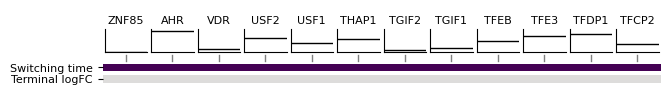

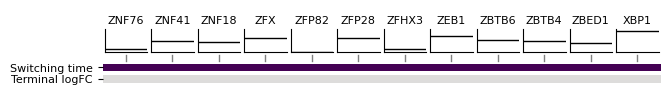

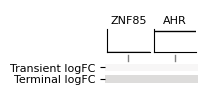

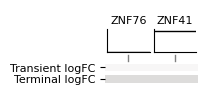

Germinal-Center


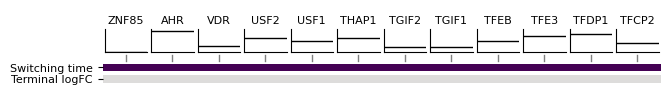

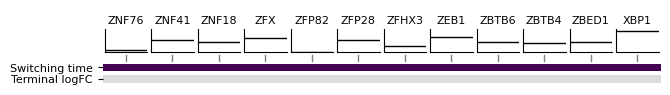

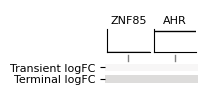

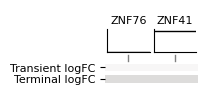

In [8]:
#Trajectory branch defined as (starting node, ending node) from trajectory inference
# bifurcation: (S2 > S1) for Plasmo-Blast and (S2 > S3) for Germinal-Center
import matplotlib.pyplot as plt

branches={
	'Plasma-Blast':(2,1),
	'Germinal-Center':(2,3)
}
#Value range for coloring
vrange={
	'Terminal logFC':[-4.5,4.5],
	'Transient logFC':[-1.5,1.5],
	'Switching time':[0.001,0.01],
}

for branchname in branches:
	print(branchname)
	figs=d0.draw_discover(*branches[branchname],ntops=(12,12,2,2),vrange=vrange)
	plt.show()

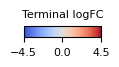

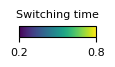

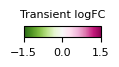

In [9]:
from operator import or_
from functools import reduce
from dictys.plot import colorbar

#Color bar font size
fs=8

colormaps=reduce(or_,[x[2] for x in figs])
for xi0 in range(len(colormaps)):
	xi=list(colormaps)[xi0]
	colormap=colormaps[xi]
	ans2=colorbar(colormap.cmap.name,colormap.norm.vmin,colormap.norm.vmax,orientation='horizontal',figsize=(1,0.15),title=xi,title_fontsize=fs)
	xticks=[colormap.norm.vmin,0,colormap.norm.vmax] if colormap.norm.vmin*colormap.norm.vmax<0 else [colormap.norm.vmin,colormap.norm.vmax]
	ans2[1].set_xticks(xticks)
	ans2[1].tick_params(axis='x',labelsize=fs)

Animation visualization of dynamic networks
Animation layout

Here we use the 'notch' layout. Each row for c,d,e,f has their own set of select TFs. The layout is arbitrary and you can design your own custom layout.

+---+       +---+
| a |       | b |
+---+---+---+---+
| c | d | e | f |
+---+---+---+---+
| c | d | e | f |
+---+---+---+---+

    a: Dynamic tracking of cells used for GRN inference
    b: Dynamic scatter plot for differential regulation v.s. differential expression logFCs
    c: Dynamic plot for expression level (log CPM) of select TFs as a function of pseudo-time
    d: Dynamic plot for regulatory activity (log target count) of select TFs as a function of pseudo-time
    e: Dynamic heatmap for regulation strength from select TFs to select target genes
    f: Dynamic subnetwork graph from select TF to its targets


In [1]:
from IPython.display import FileLink
from dictys.plot import layout,panel
# Number of frames (interpolated time points), use 100 or higher for finer resolution
nframe=100
# Animation FPS for saving. Determines speed of play
fps=0.10*nframe
# DPI for animation
dpi=100

## per branch plots

In [23]:
# specify branch specific 
branchname='Plasma-Blast'
# Select TFs for each row's dynamic subnetwork graph
tfs_subnet=[
	['IRF4'],
    ['IRF8']
]
# Select TFs for each row's other plots
tfs_ann=[
	['IRF4', 'IRF8'],
	['PRDM1', 'BCL6'],
]
# Select genes to annotate as targets in all rows
target_ann=['IRF4','IRF8','PRDM1','BCL6']

In [1]:
import matplotlib.animation
branch=branches[branchname]
# Draw dynamic network with notch layout
layout1=layout.notch(nframe=nframe,dpi=dpi)
pts,fig,panels,animate_ka=layout1.draw(
	d0,branch,
	# Set genes to annotate
	bcde_tfs=tfs_ann,e_targets=target_ann,f_tfs=tfs_subnet,
	# Custom legend location for long cell type name
	a_ka={'scatterka':{'legend_loc':(0.6,1)}},
	# Custom configurations for color range
	e_ka={'lim':[-0.02,0.02]},
)
ca=panel.animate_generic(pts,fig,panels)
anim=ca.animate(**animate_ka)


KeyboardInterrupt: 

ImportError: numpy._core.multiarray failed to import

In [ ]:
#Saving animation
#Option 2: Save animation to mp4 file
# If you receive a codec related error, try a different codec, e.g. with `codec='h264'`. You can list available codecs with `ffmpeg -codecs`.
w=matplotlib.animation.writers['ffmpeg_file'](fps=fps,codec='mpeg4')
w.frame_format='jpeg'
fo=f'/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/output/animation-{branchname}.mp4'
anim.save(fo,writer=w,dpi='figure')
display(FileLink(fo))

In [26]:
# Visualize animation within jupyter. This will make the notebook large especially with many frames
from IPython.display import HTML
HTML(anim.to_jshtml())